---
title: Project overview
author: John Sundh
date: last-modified
format: 
    confluence-html:
        code-fold: true
toc: true
toc-depth: 6
toc-expand: 3
jupyter: python3
---

**Description**

This project aims to study the effects of dibutyl phthalate (a plastic-derived contaminant) on the fecal microbiome composition and functional profile in three generations of mice (F0 "exposed mice" and F1 and F2 "offsprings"). Shotgun metagenomic sequencing of the DNA samples was done at NGI, Stockholm.

Specific goals include:

- To identify the taxonomic composition and profiling (species level), assess community diversity and characterize the relative abundances of taxa between the phthalates-treated mice vs. untreated mice (controls)
- Deep functional characterization of the phthalate-treated mice and control mice focusing on antibiotic resistance genes, virulence factors, carbohydrate metabolism, functional redundancy, etc
- To perform correlation analysis with other findings observed in F0, F1 and F2 mice, including immune, metabolic and liver phenotypes


In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib_inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import umap
import altair as alt
alt.renderers.enable("html")
#from vega_datasets import data
from skbio.stats.composition import clr as skbio_clr
from sklearn.decomposition import PCA
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
sns.set_style("whitegrid")

In [2]:
def read_h5(filename):
    """
    Reads a hdf file with h5py package and returns a data frame
    """
    with h5py.File(filename, 'r') as hdf_file:
        data_matrix = hdf_file['data'][:]
        sample_names = hdf_file['data'].attrs['sample_names'].astype(str)
    return pd.DataFrame(dict(zip(sample_names, data_matrix)))

def read_bin_qc(f, binner):
    df = pd.read_csv(f, header=0, sep="\t", index_col=0)
    df = df.assign(sample_id=pd.Series([x.split("_")[0] for x in df.index], index = df.index))
    df = df.assign(binner=pd.Series([binner]*df.shape[0], index=df.index))
    df = df.assign(Mbp=pd.Series([x / 1000000 for x in df["Genome_Size"]], index=df.index))
    return df

def clr(data, log=np.log2, method="custom"):
    """
    Convert counts data to centered log ratio with log2. 
    Zeros are replaced by multiplicative_replacement from scikit-bio. 
    See wikipedia for centered log ratio.
    Taken from https://github.com/metagenome-atlas/Tutorial/blob/master/Python/utils/mag_scripts.py
    
    Rows should be samples and columns should be features
    """

    from skbio.stats import composition

    # remove columns with all zeros
    data = data.loc[:, ~(data == 0).all()]

    # dataframe with replaced zeros
    data = pd.DataFrame(
        composition.multiplicative_replacement(data),
        columns=data.columns,
        index=data.index,
    )
    if method == "custom":
        data = log(data)
        return (data.T - data.mean(1)).T
    elif method == "skbio":
        _ = pd.DataFrame(skbio_clr(data))
        _.columns = data.columns
        _.index = data.index
        return _

def add_unassigned(df):
    """
    Adds taxnames for unassigned labels
    """
    for mag, lineage in df.iterrows():
        last_known = ""
        for rank, taxname in lineage.items():
            if taxname != taxname:
                df.loc[mag, rank] = f"Unclassified.{last_known}"
            else:
                last_known = taxname
    return df

# Project overview

## Summary

As of 24 May 2023, roughly 37 hours (out of 80 hours contracted) had been used. Completed tasks are shown below:

| task name | comment | estimated time (h) | completed |
| --------- | ------- | ------------------ | --------- |
| Sample preprocessing | Read trimming, filtering and QC | 10 | yes |
| Metagenomic assembly | Assembly and evaluation (e.g. N50, reads mapped etc.) | 15 | yes |
| Metagenomic binning | Group assembled contigs into genome bins (including taxonomic assignment of hiqh-quality bins) | 15 | yes |
| Metagenomic annotation | e.g. eggnog-mapper, CAZY db | 15 | in-part |
| Taxonomic profiling | Using e.g. Metaphlan/Kraken2 with preprocessed reads | 5 | in-part |
| Taxonomic assignment | Assign taxonomy to assembled contigs using e.g. MMSeqs2 | 10 | ongoing |
| Identification of virulence factors | Identify VFs in samples, potentially using genome bins  | 10 | no |

Clustering and annotation of the 105 assemblies generated 1,985,841 non-redundant proteins which were annotated functionally against various databases. Binning of the assemblies produced 262 genomes (clustered at 95% identity). The most abundant taxa based on these genomes were Bacteroidia, Clostridia and Bacilli. F0 generation mice appear to have a greater diversity. Ongoing work includes assigning taxonomy to assembled contigs, which will work as a supplement to the taxonomic assignments of the 262 genomes, and also include taxonomic composition of eukaryotes.

## Git repository

A GitHub repository was created for the project and is available at [https://github.com/NBISweden/SMS-23-6668-micegut](https://github.com/NBISweden/SMS-23-6668-micegut). This repository is used to track configuration files, sample lists, utility scripts and documentation for the project. Actual results will be shared elsewhere.

## Uppmax info

The project compute account used is: SNIC 2022/5-350 (snic2022-5-350)

The project GitHub repository listed above was cloned into `/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut` on the Rackham cluster. Analysis was executed from this directory.

### Raw data location

Raw data is stored on Uppmax at:

`/proj/snic2020-5-486/dbp_gut_microbiome/DataDelivery_2023-01-10_15-17-23_ngisthlm00104/files/P27457/`

## Samples

A total of 108 samples were divided into 10 assembly groups:

In [3]:
sample_df = pd.read_csv("../data/sample_list_atlas.tsv", header=0, sep="\t", index_col=0)
sample_df.sort_values("BinGroup", inplace=True)
group_df = pd.DataFrame(sample_df.groupby("BinGroup").size(), columns=["samples"]).sort_index()
sample_dict = sample_df.to_dict(orient="index")
group_df.sort_index().T

BinGroup,F0_C,F0_H,F0_L,F1_C,F1_H,F1_L,F2_C,F2_H,F2_L
samples,12,12,10,8,8,6,16,16,17


In [4]:
sample_info = sample_df.drop(["Reads_raw_R1","Reads_raw_R2"], axis=1)
sample_info.rename(columns = {'BinGroup': 'Group'}, inplace=True)
sample_info = sample_info.assign(Treatment=pd.Series([x.split("_")[-1] for x in sample_info.Group], index=sample_info.index))
sample_info = sample_info.assign(Generation=pd.Series([x[0:2] if x!="mock" else x for x in sample_info.Group], index=sample_info.index))
sample_info.index.name = "sample_id"
sample_info = sample_info.assign(Sample=pd.Series([x.split("-")[0] for x in sample_info.index], index=sample_info.index))

# Methods

## Initial strategy

Initially I looked into using the [nf-core/mag](https://nf-co.re/mag) Nextflow pipeline for this project. However, after some trial runs I found that the pipline is likely not suited for this analysis. This could also be due to my lack of detailed knowledge and experience with debugging Nextflow pipelines but nevertheless I turned to other alternatives. My attempts at using `nf-core/mag` is documented at [doc/nf-core-mag.ipynb](https://github.com/NBISweden/SMS-23-6668-micegut/blob/main/doc/nf-core-mag.ipynb).

## ATLAS

As an alternative I tried [ATLAS](https://github.com/metagenome-atlas/atlas/), a workflow written in Snakemake that performs QC, Assembly, Binning and functional annotation of contigs using gene catalogs (genes are clustered with mmseqs and annotated with eggNOG).

### Patches and modifications

**GUNC**

Atlas runs the [GUNC](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02393-0) tool on binned genomes in order to check for chimeras. However the version used in atlas is incompatible with `pandas` v2.0*. Therefore I manually set the pandas version to `1.5.3` in the file `/crex/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/envs/atlas/lib/python3.10/site-packages/atlas/workflow/envs/gunc.yaml`, removed the already installed conda environment and restarted Atlas.

**DRAM**

For the genome annotation Atlas runs [DRAM](https://academic.oup.com/nar/article/48/16/8883/5884738?login=false). In the conda environment created there was some issue with perl on Uppmax that caused the `tRNAscan-SE` program to fail. [Speaking](https://github.com/UCSC-LoweLab/tRNAscan-SE/issues/23) with the `tRNAscan-SE` developers I got a custom perl module (`CM.pm`) that I used to replace the conda-installed module inside the corresponding environment: `cp src/CM.pm $CONDA_PREFIX/lib/tRNAscan-SE/tRNAscanSE/CM.pm`. To use it I ran atlas with the flag `--conda-create-envs-only` and the `genomes` target. Then substituted the `Cm.pm` script inside the relevant conda environment.

In atlas, DRAM also requires a configuration file to be passed to `DRAM.py annotate` and `DRAM.py distill`with `--config_loc`. This configuration file is located at `/crex/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/resources/DRAM/DRAM.config`

The `dram.smk` file in the atlas source code was therefore updated with:

```python
rule DRAM_annotate:
    input:
...
        config=get_dram_config,
...
    shell:
...
        " --config_loc {input.config} "
...
rule DRAM_destill:
    input:
...
        config=get_dram_config,
...
    shell:
...
        " --config_loc {input.config} "    
...
rule get_all_modules:
    input:
        "genomes/annotations/dram/annotations.tsv",
        get_dram_config,
...
```

and the `DRAM_get_all_modules.py` script was modified to contain:

```python
database_handler = DatabaseHandler(logger=logging, config_loc=snakemake.input[1])
```

In addition, atlas expects there to be both `rrnas.tsv` and `trnas.tsv` files output by DRAM for each annotated mag under `genomes/annotations/dram/intermediate_files` but when no rRNA or tRNA sequences are identified these files are not present. I therefore added a script `scr/add_missing_annotations.py` that adds empty placeholders for these files. This script can be run as:

```bash
python src/add_missing_annotations.py atlas/genomes/annotations/dram/intermediate_files
```

### Set up

To install I ran:

```bash 
export CONDARC="/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/.condarc"
mamba env create -f atlas-env.yml -p envs/atlas
```

As a starting point I copied the `template_config.yaml` file from the atlas package into `conf/atlas-config.yml`

```bash
cp $CONDA_PREFIX/lib/python3.10/site-packages/atlas/workflow/config/template_config.yaml conf/atlas-config.yml
```

The config file `conf/atlas-config.yml` was updated to give 20 threads and 128 GB memory to the megahit assembler.

**Map quality filtering**

Because atlas version 2.15.0 does not include any filtering of mapped reads I modified the atlas source code to allow passing `minmapq` to the `pileup.sh` script used when calculating coverages. These changes are tracked at [https://github.com/johnne/atlas](https://github.com/johnne/atlas). After these modifications I set `minimum_map_quality: 10` in the atlas config.

#### Sample list

A sample list was created with:

```bash
python src/make_sample_list.py atlas > data/sample_list_atlas.tsv
```

A separate sample list was also created that excluded `mock` samples: `data/sample_list_atlas_nomock.tsv`

Set up output dir:

```bash
mkdir atlas
cd atlas
ln -s ../data/sample_list_atlas.tsv samples.tsv
```

#### Setting up cluster execution

To use the cluster profile for ATLAS I ran:
```bash
cookiecutter --output-dir ~/.config/snakemake https://github.com/metagenome-atlas/clusterprofile.git
```

and used defaults when prompted.

I then updated the `~/.config/snakemake/cluster/cluster_config.yaml` file to be:

```yaml
__default__:
  #queue: normal
  account: "snic2022-5-350"

rulename:
  queue: long
  account: ""
  time_min:  # min
  threads:
```

and set the `~/.config/snakemake/cluster/config.yaml` file to contain:

```yaml
restart-times: 0
cluster-config: "/domus/h1/john/.config/snakemake/cluster/cluster_config.yaml" #abs path
cluster: "scheduler.py" #
cluster-status: "slurm_status.py" #
max-jobs-per-second: 10
max-status-checks-per-second: 10
cores: 99 # how many jobs you want to submit to your cluster queue
local-cores: 1
rerun-incomplete: true  # recomended for cluster submissions
keep-going: true
reason: true
printshellcmds: true
```

## QC

Raw reads were preprocessed using [BBMap](https://www.osti.gov/biblio/1241166) `v39.01`.

## Assembly

Preprocessed reads were assembled for each sample using [Megahit](https://academic.oup.com/bioinformatics/article/31/10/1674/177884) `v1.2`.

## Annotation

The `atlas run genecatalog` step performs annotation of either assembled contigs or binned genomes. Here we will use the assembled contigs as input. Genes on contigs are first filtered to remove very short genes (<270 bp). 

The remaining protein sequences are then clustered with MMseqs2. For the mice gut samples I chose to cluster at 100% identity (`--min-seq-id 1.0`), requiring a 95% coverage of the target sequence (`-c 0.95 --cov-mode 1`) and with a cluster mode to suppress fragments from becoming representative sequences (`--cluster-mode 2`). These settings were largely taken from [Delgado & Andersson 2022](https://doi.org/10.1186/s40168-022-01259-2).

Representatives sequences are then annotated using [eggNOG-mapper](http://eggnog-mapper.embl.de/).

## Binning

**General overview of metagenomic binning**

Genome binning refers to the process of grouping assembled contigs into collections, or 'bins', that resemble the genomes in the original sample. This is done by comparing the composition (via frequencies of short nucleotide sequences, typically tetramers) of all contigs as well as their abundance distribution across samples. Because genomes are known to differ in their nucleotide composition (_e.g._ GC content) and because the abundance distribution of sequences (contigs) from a genome should follow the distribution patterns of the organism harboring the genome these two sources of information can be used as input to binning tools that perform unsupervised "binning" of contigs. The algorithms are never perfect though so additional checks are put in place to measure both the completeness of each bin (how much of the original genome was placed into the bin) as well contamination (how much of the bin comes from multiple sources of genomes). 

Some of the strengths of binning are that the collection of contigs in a bin can be more robustly annotated in terms of taxonomy (often using multiple single-copy core genes and phylogenetic placement into reference phylogenies), and also in terms of function because _e.g._ the metabolic potential of the bins can be estimated using multiple annotated enzymes, KEGG orthologs _etc._

The bins can also be quantified in the genome and a taxonomic composition can be created for each sample using the bin abundances.

The binning tools supported in Atlas are:

- Metabat2
- MaxBin2
- vamb

The `vamb` binner is a fairly new tool that uses deep learning to maximize the number of high quality bins. 

The output from these binners is then evaluated using [DASTool](https://github.com/cmks/DAS_Tool) to select a non-redundant set of hiqh-quality bins. Then, because the same or highly similar genomes can be binned in more than one sample, the tool [dRep](https://www.nature.com/articles/ismej2017126) is used to de-replicate bins into a non-redundant set across samples. This de-replicated set of genomes are what's called 'MAGs' for **M**etagenome **A**ssembled **G**enome.

**Quantifying MAGs**

Each MAG is then quantified in the samples by mapping QC:d reads against the contigs and calculating median coverage. 

**Taxonomic annotation of MAGs**

Each MAG output from `dRep` is also assigned a taxonomy using GTDB-Tk, a toolkit that uses phylogenetic placement of MAGs based on concatenated alignments of single-copy core genes to label MAGs with taxonomy.

Combining the coverage and taxonomic results for MAGs we can build a taxonomic profile for each sample.

**Annotation of MAGs**

Once we have obtained MAGs from our dataset we can apply basically any type of functional annotation using contigs or predicted genes to characterize the metabolic potential of the organisms. In Atlas, MAGs are annotated functionally with [DRAM](https://academic.oup.com/nar/article/48/16/8883/5884738).

### Mock benchmark

In [5]:
mock_genome_sizes = {
    'Pseudomonas aeruginosa': 6792330, 
    'Bacillus subtilis': 4045677, 
    'Bacillus spizizenii': 4045677,
    'Salmonella enterica': 4809318, 
    'Saccharomyces cerevisiae': 12843354, 
    'Staphylococcus aureus': 2730326, 
    'Enterococcus faecalis': 2845392, 
    'Listeria monocytogenes': 2992342,
    'Listeria monocytogenes_B': 2992342,
    'Lactobacillus fermentum': 1905333,
    'Limosilactobacillus fermentum': 1905333,
    'Cryptococcus neoformans': 29176277, 
    'Escherichia coli': 4875441}

For the three mock samples, the Genecatalog and binning steps were performed in a separate work directory `atlas-mock`. The mock samples are from  ZymoBIOMICS™ Microbial Community DNA Standard. It consists of 8 bacterial and 2 eukaryotic species (yeast). The theoretical composition (%) is:

| Species | DNA | 16S | 16S/18S | Genome copy | Cell number | Genome size (bp) |
| ------- | -- | -- | -- | -- | -- | -- |
| Pseudomonas aeruginosa | 12 | 4.2| 3.6 | 6.1 | 6.1| 6792330 |
| Escherichia coli | 12 | 10.1 | 8.9 | 8.5 | 8.5 | 4875441 |
| Salmonella enterica | 12 | 10.4 | 9.1 | 8.7 | 8.7 | 4809318 |
| Lactobacillus fermentum | 12 | 18.4 | 16.1 | 21.6 | 21.4 | 1905333 |
| Enterococcus faecalis | 12 | 9.9 | 8.7 | 14.6 | 14.5 | 2845392 |
| Staphylococcus aureus | 12 | 15.5 | 13.6 | 15.2 | 15.1 | 2730326 |
| Listeria monocytogenes | 12 | 14.1 | 12.4 | 13.9 | 13.8 | 2992342 |
| Bacillus subtilis | 12 | 17.4 | 15.3 | 10.3 | 10.2 | 4045677 |
| Saccharomyces cerevisiae | 2 | NA | 9.3 | 0.57 | 1.13 | 12843354 |
| Cryptococcus neoformans | 2 | NA | 3.3 | 0.37 | 0.73 | 29176277 |

In a first trial with more or less default settings on the mock the `vamb`, `maxbin2` and `metabat2` binners identified 24 (8+8+8), 26 (8+8+10) and 38 (14+12+12) bins across all three mock samples. The bin-conciler DASTool generated a total of 41 bins (13+13+15) from these three tools. We know that there should be 10 genomes in each sample, and two of these are eukaryotic. Typically eukarytoic genomes are more difficult to bin, and also to get reliable quality estimates of. Furthermore, the atlas workflow is not really designed to handled eukaryotic reads/bins so if these are of interest they should be analysed using other tools. The assemblies from megahit could probably be used though.

Below we take a look at the different bin sets generated in terms of Completeness and Contamination, commonly used quality metrics for bins.

In [6]:
bin_qc = pd.concat([
    read_bin_qc("../atlas-mock/Binning/vamb/checkm2_quality_report.tsv", "vamb"),
    read_bin_qc("../atlas-mock/Binning/maxbin/checkm2_quality_report.tsv", "maxbin"),
    read_bin_qc("../atlas-mock/Binning/metabat/checkm2_quality_report.tsv", "metabat"),
    read_bin_qc("../atlas-mock/Binning/DASTool/checkm2_quality_report.tsv", "DASTool")
])

In [7]:
source = bin_qc.reset_index()
base = alt.Chart(source)
w=400
h=400
yscale = alt.Scale(domain=(0, 100))
xscale = alt.Scale(domain=(0, 100))

bar_args = {'opacity': 1, 'binSpacing': 0}

points = base.mark_circle().encode(
    alt.X('Contamination').scale(xscale),
    alt.Y('Completeness').scale(yscale),
    color='binner', size="Mbp",
    tooltip=["Bin Id", "sample_id", "Completeness", "Contamination", "Genome_Size", "binner"],   
).properties(width=w, height=h)

top_hist = base.mark_bar(**bar_args).encode(
    alt.X('Contamination:Q')
          # when using bins, the axis scale is set through
          # the bin extent, so we do not specify the scale here
          # (which would be ignored anyway)
          .bin(maxbins=20, extent=xscale.domain)
          .stack(None)
          .title(''),
    alt.Y('count()').stack(None).title(''),
    alt.Color('binner:N'),
    row="binner"
).properties(height=30, width=w)

right_hist = base.mark_bar(**bar_args).encode(
    alt.Y('Completeness:Q')
          .bin(maxbins=20, extent=yscale.domain)
          .stack(None)
          .title(''),
    alt.X('count()').stack(None).title(''),
    alt.Color('binner:N'),
    column="binner"
).properties(width=30, height=h)

top_hist & (points | right_hist)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_ar

alt.VConcatChart(...)

Best here is to have most bins in the top left corner (high completeness and low contamination). We can see that both DASTool and vamb have most bins in this area, while the two others also have a spread of bins in the medium completeness and contamination range.

Commonly used values for these two metrics are Contamination<10% and Completeness>=50%. These are the criteria used to define a "Medium quality MAG" according to [Bowers et al 2017](https://www.nature.com/articles/nbt.3893). When applying these criteria we get the following number of bins:

In [8]:
source = pd.DataFrame(bin_qc.loc[(bin_qc.Completeness>=50)&(bin_qc.Contamination<=10)].groupby(["sample_id","binner"]).size()).reset_index()
source.rename(columns={0: "0"}, inplace=True)
alt.Chart(source).mark_bar().encode(
    y=alt.Y("binner").sort("-x"), x=alt.X("0", title="Number of bins (Medium quality or better)"), color="sample_id",
    tooltip=["sample_id"]
)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

This shows that DASTool and vamb both generate 8 bins per sample (the expected number of bacterial genomes). A quick check of the predicted taconomy of these bins with `sourmash` indicated that these 8 bins corresponded to the expected species in the mock community. Interestingly, for the bins generated by DASTool _B. subtilis_ was consistently not classified correctly. This seemed to be because DASTool chose one of the maxbin2 bins instead of vamb for this genome.

**In summary, vamb seems to perform better than a combination of vamb+metabat2+maxbin2 followed by DASTool.**

Proceeding with the filtering (Completeness >=50%, Contamination <10%) and de-replication (at 95% average nucleotide identity) of the vamb bins generated 8 MAGs. 

In [9]:
# Read genome quality
genome_qual = pd.read_csv("../atlas-mock/genomes/genome_quality.vamb.tsv", header=0, sep="\t", index_col=0)
# Read taxonomy from GTDB
genome_tax = pd.read_csv("../atlas-mock/genomes/taxonomy/gtdb_taxonomy.vamb.tsv", header=0, sep="\t", index_col=0)
genomes = pd.merge(genome_qual.loc[:, ["Completeness","Contamination","genome_size"]], genome_tax.loc[:, "species"], left_index=True, right_index=True)
genomes = pd.merge(genomes, pd.DataFrame(mock_genome_sizes, index=["Actual genome size"]).T, left_on="species", right_index=True)
genomes = genomes.assign(percent_binned=pd.Series(genomes["genome_size"] / genomes["Actual genome size"] * 100, index=genomes.index))

# Read quantification results
median_genomes = pd.read_parquet("../atlas-mock/genomes/counts/median_coverage_genomes.vamb.parquet")
median_genomes.set_index("index", inplace=True)
median_genomes = median_genomes.T
relab_genomes = median_genomes.div(median_genomes.sum())*100
mock_genomes = pd.merge(genomes, relab_genomes, left_index=True, right_index=True)
mock_genomes.index.name="MAG"

Below left is a plot of how much of the actual genome was recovered in each MAG (total binned bp divided by the known genome size). The right panel shows the relative abundance of each MAG in the samples.

In [10]:
source1 = pd.melt(mock_genomes.reset_index(), id_vars=["MAG","species"], value_vars=["m.c","m.c-2", "m.c-3"], var_name="sample_id", value_name="%")
source2 = pd.melt(mock_genomes.reset_index(), id_vars=["MAG","species"], value_vars=["percent_binned"], value_name="% binned")
c1 = alt.Chart(source1, title="Relative abundance").mark_bar().encode(
    x=alt.X('%').stack("normalize"),
    y='species',
    color=alt.Color("sample_id"),
    tooltip=["MAG", "%", "sample_id"]
)
c2 = alt.Chart(source2).mark_bar().encode(
    x=alt.X('% binned'),
    y='species',
    tooltip=["MAG", "% binned"],)
c2|c1

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.HConcatChart(...)

As we can see, each of the 8 bacterial species in the mock samples were recovered at between 88 - 97% of the actual genome size. Further, the relative abundance of the genomes were identified to a 12.5% mean, very close to the theoretical 12% described in the mock documentation.

## Taxonomic annotation of contigs

Taxonomy can be assigned directly for assembled contigs in various ways.

Included in the project repository is an extra Snakemake workflow that performs taxonomic annotation of contigs using `mmseqs2`. As taxonomic database it can use centrally stored taxonomic databases formatted for `mmseqs2`. These are stored on Uppmax at `/sw/data/MMseqs2_data/20230125/rackham/`. Symlinks were created under `resources/mmseqs2/` to the following:

- NR
- UniProtKB
- UniRef100
- UniRef90

These databases have a timestamp of `20230125`.

In theory we could use mmseqs2 to assign taxonomy to the assembled contigs in order to obtain taxonomic profiles of both prokaryotes and eukaryotes.

To assign taxonomy to the assembled contigs, we run the following:

```bash
snakemake --profile profiles/slurm 
```

# Results

For the atlas workflow, `/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/atlas/` was used as an output directory.

## QC

The `atlas run qc` command runs the BBTools suite to preprocess samples (incl. duplicate removal, quality trimming, adapter removal and phiX and host reads removal).

Here's how the qc command was executed:

```bash
atlas run -w /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/atlas -c /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/conf/atlas-config.yml --profile cluster qc
```

Because atlas doesn't come with fastqc/multiqc I added these dependencies to the atlas-env.yml file and updated the environment which installed `fastqc=0.12.1` and `multiqc=1.14`.

To run multiqc on the preprocessed files I added a small workflow file (`src/multiqc.smk`) which can be used as:

```bash
snakemake -s src/multiqc.smk --profile profiles/extra
```

Checking the resulting `atlas/multiqc/multiqc_report.html` shows that all samples passed QC. Below are plots of total reads that passed QC in all samples.

In [11]:
mqc_df = pd.read_csv("../atlas/multiqc/multiqc_data/multiqc_general_stats.txt", header=0, sep="\t", index_col=0, usecols=[0,11])
mqc_df.rename(columns = lambda x: x.replace("FastQC_mqc-generalstats-fastqc-", ""), inplace=True)
mqc_df = mqc_df.loc[(mqc_df.index.str.contains("_R1"))&(~mqc_df.index.str.contains("deduplicated"))]
mqc_df.rename(index=lambda x: x.replace("_QC_R1", ""), inplace=True)
mqc_df = pd.merge(mqc_df, sample_info, left_index=True, right_index=True)
mqc_df.index.name="sample_id"

In [12]:
alt.Chart(mqc_df.reset_index(), title="Total sequences passing QC").mark_bar().encode(
    y="total_sequences",
    x=alt.X("sample_id").sort("color"),
    color="Group",
    tooltip=["sample_id","total_sequences","Group"]
).properties(
    width=600,
    height=200
)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [13]:
alt.Chart(mqc_df, title="Sequences per group").mark_boxplot().encode(
    x="total_sequences",
    y=alt.Y("Group"),
    color="Treatment"
).properties(
    width=400,
    height=300
)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

This shows that there are between ~12 - 30 M reads remaining after QC, with no obvious biases in terms of read numbers for samples/groups.

## Assembly

Here's how atlas was executed for assembly:

```bash
atlas run -w /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/atlas -c /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/conf/atlas-config.yml --profile cluster assembly
```

**Assembly stats**

In [14]:
asm_stats = pd.read_csv("../atlas/stats/combined_contig_stats.tsv", header=0, sep="\t", index_col=0)
asm_stats = asm_stats.assign(AssemblySize=pd.Series([round(x/1000000, 2) for x in asm_stats.contig_bp], index=asm_stats.index))
asm_stats.index.name="sample_id"
asm_stats.rename(columns={'n_contigs': "Contigs", "AssemblySize": "Assembly size (Mbp)"}, inplace=True)
asm_stats = pd.merge(asm_stats, sample_info, left_index=True, right_index=True)

Common assembly statistics used here are:

* N50 = 50% of the assembly is contained in this many contigs (in descending length)
* L50 = length of the shortest contig in the set made up by `N50`
* Assembly size (Mbp) = Total assembly size in Mbp
* N_Predicted_Genes = number of genes predicted in the assembly by the `prodigal` gene caller
 
In general, a low N50 and a high L50 is preferrable.

Below is a plot of N50 vs. L50 values for all assemblies. Hover over the points for more information about the assembly. You can change the opacity and size of the points.

In [15]:
op_slider = alt.binding_range(min=0, max=1, step=0.05, name='opacity:')
op_var = alt.param(value=0.7, bind=op_slider)

si_slider = alt.binding_range(min=50, max=200, step=10, name="point size:")
si_var = alt.param(value=50, bind=si_slider)
si_var2 = alt.param(value=200, bind=si_slider)
dropdown_x = alt.binding_select(
    options=["N50","L50","Contigs","Assembly size (Mbp)", "N_Predicted_Genes"],
    name="X-axis column"
)
dropdown_y = alt.binding_select(
    options=["N50","L50","Contigs","Assembly size (Mbp)", "N_Predicted_Genes"],
    name="Y-axis column"
)
xcol_param = alt.param(
    value="L50",
    bind=dropdown_x
)
ycol_param = alt.param(
    value="N50",
    bind=dropdown_y
)

In [16]:
alt.Chart(asm_stats.reset_index()).mark_circle(size=si_var, opacity=op_var).encode(
    x="N50", y="L50", color="Treatment",
    tooltip=["sample_id","Contigs","Assembly size (Mbp)", "N50","L50", "N_Predicted_Genes", "Group"]
).add_params(
    op_var, si_var,
).properties(width=400, height=400)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

Below is a chart where you can choose other statistics to plot against each other.

In [17]:
alt.Chart(asm_stats.reset_index()).mark_circle(size=si_var, opacity=op_var).encode(
    x=alt.X("x:Q").title('X-axis column'), y=alt.Y("y:Q").title("Y-axis column"), color="Treatment",
    tooltip=["sample_id","Contigs","Assembly size (Mbp)", "N50","L50", "N_Predicted_Genes", "Group"]
).transform_calculate(
    x=f'datum[{xcol_param.name}]',
    y=f'datum[{ycol_param.name}]'
).add_params(
    op_var, si_var, xcol_param, ycol_param
).properties(width=400, height=400)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

The `mock` samples have high L50 values indicating assemblies with long contigs, but at the same time have a low number of predicted genes and low total assembly size. This is to be expected from samples with low complexity.

**Technical replicates**

Because we have technical replicates for a few samples we can look specifically at how these fair in the assembly and if the results are similar. Below are plots of assembly stats, but only showing samples with technical replicates.

In [18]:
tr_samples = asm_stats.loc[(asm_stats.index.str.contains("t.r"))|(asm_stats.index.str.startswith("m.c"))].Sample
trs = asm_stats.loc[asm_stats.Sample.isin(tr_samples)]

In [19]:
h = 300
w = 300
chart1 = alt.Chart(trs.reset_index()).mark_circle(size=si_var2, opacity=op_var).encode(
    x="L50", y="N50", color="Sample",
    tooltip=["sample_id","Contigs","Assembly size (Mbp)", "N50","L50", "N_Predicted_Genes", "Group"]
).add_params(
    op_var, si_var2,
).properties(width=w, height=h)

chart2 = alt.Chart(trs.reset_index()).mark_circle(size=si_var2, opacity=op_var).encode(
    x=alt.X("Contigs").title("#contigs"), y=alt.Y("contig_bp").title("Assembly size (bp)"), color="Sample",
    tooltip=["sample_id","Contigs","Assembly size (Mbp)", "N50","L50", "N_Predicted_Genes", "Group"]
).add_params(
    op_var, si_var2,
).properties(width=w, height=h)

#chart1 | chart2
alt.vconcat(chart1, chart2)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_ar

alt.VConcatChart(...)

In [20]:
alt.Chart(trs.reset_index()).mark_circle(size=si_var2, opacity=op_var).encode(
    x=alt.X("x:Q").title('X-axis column'), y=alt.Y("y:Q").title("Y-axis column"), color="Sample",
    tooltip=["sample_id","Contigs","Assembly size (Mbp)", "N50","L50", "N_Predicted_Genes", "Group"]
).transform_calculate(
    x=f'datum[{xcol_param.name}]',
    y=f'datum[{ycol_param.name}]'
).add_params(
    op_var, si_var2, xcol_param, ycol_param
).properties(width=400, height=400)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In summary,  the technical replicates have very similar assemblies, in terms of these statistics.

## Annotation

In [21]:
def sum_cov_to_features(annot_df, cov_df, feature_col, split):
    """
    Sums up coverage values to each feature in <feature_col>.
    If more than one feature value is given in the feature column, specify <split> string to
    sum values for each feature of the gene.
    
    Example:
    Query       KO                  sample1 sample2
    Gene1771268 ko:K02412,ko:K03224     100      10
    
    becomes:
    KO        sample1 sample2
    ko:K02412     100      10
    ko:KO3224     100      10
    
    with split=";"
    """
    df = annot_df.loc[annot_df[feature_col]!="-"]
    df = pd.merge(df.loc[:, feature_col], cov_df, left_index=True, right_index=True)
    df = df.groupby(feature_col).sum()
    rows = []
    feats = []
    for feat in df.index:
        if split=="":
            iterator = feat
        else:
            iterator = feat.split(split)
        for f in iterator:
            feats.append(f)
            rows.append(df.loc[feat])
    dataframe = pd.DataFrame(rows, index=feats)
    dataframe = dataframe.groupby(level=0).sum()
    dataframe.index.name = feature_col
    return dataframe

Here is how atlas was executed for the annotation part:

```bash
atlas run -w /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/atlas -c /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/conf/atlas-config.yml --profile cluster genecatalog
```

**Results**

In total 1,985,841 gene clusters were generated in the `mmseqs` clustering step. Of these, 1,790,279 (90%) were given an annotation by eggNOG mapper.

In [22]:
#cov_stats = pd.read_csv("../atlas/Genecatalog/counts/sample_coverage_stats.tsv", sep="\t", index_col=0, header=0).T
#nmapped_reads = read_h5("../atlas/Genecatalog/counts/Nmapped_reads.h5")
median_coverage = read_h5("../atlas/Genecatalog/counts/median_coverage.h5")
gene_coverage_stats = pd.read_parquet("../atlas/Genecatalog/counts/gene_coverage_stats.parquet")
median_coverage.index = [x.split(" ")[0] for x in gene_coverage_stats["#Name"]]

eggNOG mapper assigns functions from a variety of databases using pre-computed orthologous groups. Below is a summary table of number of genes in the Genecatalog that were given a functional assignment from the different databases.

In [23]:
eggnog = pd.read_csv("../atlas/Genecatalog/annotations/eggNog.tsv.gz", header=0, sep="\t", index_col=0, comment="#")
features = ["COG_cat","GO_terms","EC","KO","KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass","BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"]
num_feat_dict = {}
for f in features:
    num_feat_dict[f] = {'Annotated genes': eggnog.loc[eggnog[f]!="-"].shape[0],
                        '% of Genecatalog': round((eggnog.loc[eggnog[f]!="-"].shape[0] / median_coverage.shape[0]) * 100, 1)}
num_feat_df = pd.DataFrame(num_feat_dict).T
num_feat_df.index.name="Feature"
num_feat_df.sort_values("Annotated genes", ascending=False)

,Annotated genes,% of Genecatalog
Feature,,
COG_cat,1608019.0,81.0
PFAMs,1581239.0,79.6
KO,769693.0,38.8
BRITE,769693.0,38.8
KEGG_Pathway,430807.0,21.7
EC,385061.0,19.4
KEGG_Module,295945.0,14.9
KEGG_Reaction,278278.0,14.0
KEGG_rclass,270087.0,13.6


In the `atlas/Genecatalog/counts` folder on Uppmax are sample-wise counts files for gene clusters and overall statistics files:

| file | contents | open with |
| ---- | -------- | ------- |
| gene_coverage_stats.parquet | name, length and GC of gene clusters | `pandas.read_parquet` |
| Nmapped_reads.h5 | reads mapped to each gene cluster in each sample | `h5py` |
| median_coverage.h5 | median fold coverage for each gene cluster in each sample | `h5py` |
| sample_coverage_stats.tsv | sum of coverage and total counts for all and non-zero genes for each sample | `pandas.read_csv` |

In addition, the `atlas/Genecatalog/alignments` directory contains individual coverage files for samples in the [parquet](https://www.databricks.com/glossary/what-is-parquet) format. These files look like this:

| GeneName | Avg_fold | Covered_percent | Read_GC | Median_fold | Std_Dev | Reads |
| -------- | -------- | --------------- | ------- | ----------- | ------- | ----- |
| Gene0000001 | 1.7038 | 69.8514 | 0.4857 | 1 | 1.66 | 13 |

The `Median_fold` values are the same as those reported for the sample in the `median_coverage.h5` file in the table above, while `Reads` corresponds to the values in the `Nmapped_reads.h5` file. The `.h5` files do not contain row names but are sorted in the same way as the `gene_coverage_stats.parquet` file so the names can be taken from there.

The atlas developer suggests to use the median coverage values to calculate relative abundance of each gene in each sample, followed by normalization using central log ratios. 

The COG category, PFAM and KO feature level are the most represented. We will sum abundances for each of these categories.

### COG category

In [24]:
# Read cog category info
cog_cats = pd.read_csv("../data/COG_categories.tsv", sep="\t", names=["COG_cat","COG_cat_name"], index_col=0)

In [25]:
cog_cat_cov = sum_cov_to_features(eggnog, median_coverage, "COG_cat", "")
cog_cat_cov = pd.merge(cog_cats, cog_cat_cov, left_index=True, right_index=True)
cog_cat_cov.set_index("COG_cat_name", inplace=True)
cog_cat_cov.to_csv("../atlas/Genecatalog/counts/COG_cat_name.median_coverage.tsv", sep="\t")

In [26]:
cog_cat_cov_relab = cog_cat_cov.div(cog_cat_cov.sum())*100
cog_cat_cov_clr = clr(cog_cat_cov.T)

In [27]:
sample_info.loc[cog_cat_cov_relab.columns]
gen_lut = dict(zip(sample_info.Generation.unique(), sns.color_palette("Set1", len(sample_info.Generation.unique()))))
treat_lut = dict(zip(sample_info.Treatment.unique(), sns.color_palette("Set2", len(sample_info.Treatment.unique()))))
sample_colors = pd.merge(
    pd.DataFrame(sample_info.loc[cog_cat_cov_relab.columns, "Generation"].map(gen_lut)),
    pd.DataFrame(sample_info.loc[cog_cat_cov_relab.columns, "Treatment"].map(treat_lut)),
    left_index=True, right_index=True
)

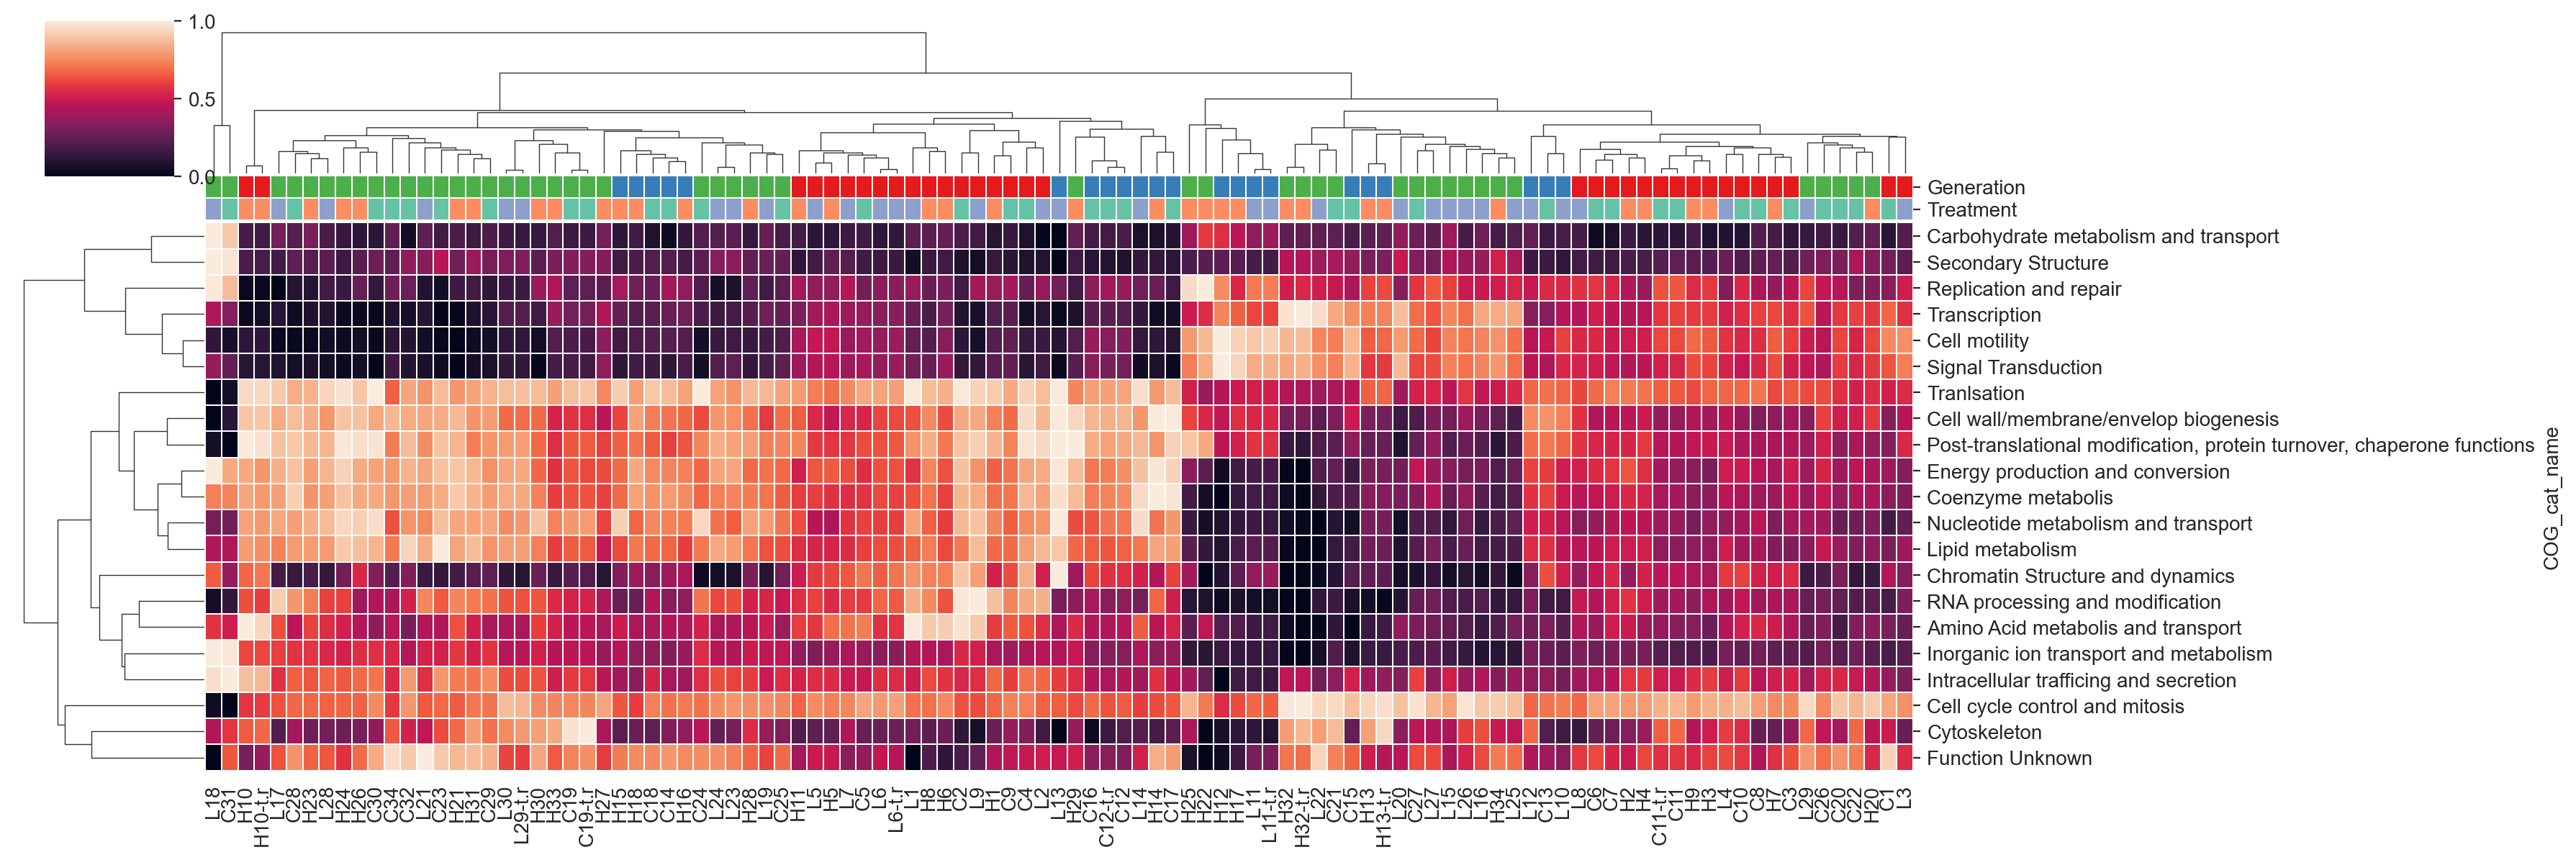

In [28]:
sns.clustermap(cog_cat_cov_relab, linewidth=.1, figsize=(18,6), metric="euclidean", standard_scale=0, 
               dendrogram_ratio=(.1, .2), col_colors=sample_colors, yticklabels=True, xticklabels=True)

### PFAMs

In [29]:
pfam_cov = sum_cov_to_features(eggnog, median_coverage, "PFAMs", ",")
pfam_cov.to_csv("../atlas/Genecatalog/counts/PFAMs.median_coverage.tsv", sep="\t")

### KEGG orthologs

In [30]:
ko_cov = sum_cov_to_features(eggnog, median_coverage, "KO", ",")
ko_cov.to_csv("../atlas/Genecatalog/counts/KO.median_coverage.tsv", sep="\t")

### CAZy

We will also save median coverage values for CAZy features

In [31]:
cazy_cov = sum_cov_to_features(eggnog, median_coverage, "CAZy", ",")
cazy_cov.to_csv("../atlas/Genecatalog/counts/CAZy.median_coverage.tsv", sep="\t")

### Projections

In [32]:
def umap_embedding(data, info_df, random_state=42, n_components=3, n_neighbors=15):
    """
    Perform UMAP fitting of data and return a dataframe with dimension coordinates
    as well as sample information
    """
    reducer = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors)
    embedding = reducer.fit_transform(data)
    umap_df = pd.DataFrame(embedding, columns=[f"UMAP{x}" for x in range(1,n_components+1)], index=data.index)
    umap_df = pd.merge(umap_df, info_df, left_index=True, right_index=True)
    umap_df.index.name = "sample_id"
    return umap_df

def extract_annot(annot_df, cov_df, feature):
    """
    Extract coverage values for genes given certain annotations
    """
    feature_genes = list(annot_df.loc[annot_df[feature]!="-"].index)
    return cov_df.loc[feature_genes]    

def pca_fit(data, info_df, random_state=42, n_components=3):
    """
    Perform PCA fitting of data and return a dataframe with dimension coordinates
    as well as sample information
    """
    pca = PCA(n_components=n_components, random_state=random_state)
    transformed_data = pca.fit_transform(data)
    pca_df = pd.DataFrame(transformed_data, columns=[f"PC {x}" for x in range(1, n_components+1)], index=data.index)
    pca_df = pd.merge(pca_df, info_df, left_index=True, right_index=True)
    pca_df.index.name = "sample_id"
    return pca_df, pca.explained_variance_ratio_

Below we take a quick look at the annotation patterns in the samples. We will use both the full Genecatalog, as well as subsets of genes given an annotation in the KEGG, CAZy and PFAM databases. The median coverage is converted to relative abundance and normalized using central log ratio. Normalized coverage is then used as input to project samples into a 2-dimensional space, using [umap](https://umap-learn.readthedocs.io/en/latest/index.html) and PCA (implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). Mock samples are excluded in this analysis.

In [33]:
# Normalize the median coverage

# Full Genecatalog
relab = median_coverage.div(median_coverage.sum())
relab_clr = clr(relab.T)

# KO subset
median_coverage_ko = extract_annot(eggnog, median_coverage, "KO")
relab_ko = median_coverage_ko.div(median_coverage_ko.sum())
relab_ko_clr = clr(relab_ko.T)

# CAZy subset
median_coverage_cazy = extract_annot(eggnog, median_coverage, "CAZy")
relab_cazy = median_coverage_cazy.div(median_coverage_cazy.sum())
relab_cazy_clr = clr(relab_cazy.T)

# PFAM subset
median_coverage_pfam = extract_annot(eggnog, median_coverage, "PFAMs")
relab_pfam = median_coverage_pfam.div(median_coverage_pfam.sum())
relab_pfam_clr = clr(relab_pfam.T)

In [34]:
def run_umap_fitting():
    # Run umap fitting
    # Full Genecatalog
    umap_df = umap_embedding(data=relab_clr.loc[~relab_clr.index.str.contains("m.c")], n_neighbors=15, 
                             info_df=sample_info)
    # KO subset
    umap_ko_df = umap_embedding(data=relab_ko_clr.loc[~relab_ko_clr.index.str.contains("m.c")],
                             info_df=sample_info)
    # CAZy subset
    umap_cazy_df = umap_embedding(data=relab_cazy_clr.loc[~relab_cazy_clr.index.str.contains("m.c")],
                             info_df=sample_info)
    # PFAM subset
    umap_pfam_df = umap_embedding(data=relab_pfam_clr.loc[~relab_pfam_clr.index.str.contains("m.c")],
                             info_df=sample_info)
    return umap_df, umap_ko_df, umap_cazy_df, umap_pfam_df
umap_df, umap_ko_df, umap_cazy_df, umap_pfam_df = run_umap_fitting()

In [35]:
# Concat all projections
umap_df["Database"] = ["Full"]*umap_df.shape[0]
umap_ko_df["Database"] = ["KO"]*umap_ko_df.shape[0]
umap_cazy_df["Database"] = ["CAZy"]*umap_cazy_df.shape[0]
umap_pfam_df["Database"] = ["PFAMs"]*umap_pfam_df.shape[0]

umap_concat = pd.concat([
    pd.melt(umap_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "UMAP1","UMAP2","UMAP3"]),
    pd.melt(umap_ko_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "UMAP1","UMAP2","UMAP3"]),
    pd.melt(umap_pfam_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "UMAP1","UMAP2","UMAP3"]),
    pd.melt(umap_cazy_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "UMAP1","UMAP2","UMAP3"])
])

**UMAP projections**

In [36]:
color="Treatment"
shape="Generation"

c1 = alt.Chart(umap_df.reset_index(), title="Genecatalog").mark_point().encode(
    x="UMAP1", y="UMAP2", color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c2 = alt.Chart(umap_pfam_df.reset_index(), title="PFAMs").mark_point().encode(
    x="UMAP1", y="UMAP2", color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c3 = alt.Chart(umap_ko_df.reset_index(), title="KEGG orthologs").mark_point().encode(
    x="UMAP1", y="UMAP2", color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c4 = alt.Chart(umap_cazy_df.reset_index(), title="CAZy").mark_point().encode(
    x="UMAP1", y="UMAP2", color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)

alt.vconcat((c1|c2), (c3|c4), data=umap_concat)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_ar

alt.VConcatChart(...)

For both the full Genecatalog and the annotated subsets there is a clear separation of samples according to mice generation. This separation is less pronounced when using `minimum_map_quality: 10` compared to the default of using no map quality filtering. However, there also appears to be some local clustering within the different generations.

In [37]:
def run_pca():
    # Run PCA
    # Full Genecatalog
    pca_df, exp_var = pca_fit(data=relab_clr.loc[~relab_clr.index.str.contains("m.c")], info_df=sample_info)
    # KO subset
    pca_ko_df, exp_var_ko = pca_fit(data=relab_ko_clr.loc[~relab_ko_clr.index.str.contains("m.c")], info_df=sample_info)
    # CAZy subset
    pca_cazy_df, exp_var_cazy = pca_fit(data=relab_cazy_clr.loc[~relab_cazy_clr.index.str.contains("m.c")], info_df=sample_info)
    # PFAM subset
    pca_pfam_df, exp_var_pfam = pca_fit(data=relab_pfam_clr.loc[~relab_pfam_clr.index.str.contains("m.c")], info_df=sample_info)
    return pca_df, exp_var, pca_ko_df, exp_var_ko, pca_cazy_df, exp_var_cazy, pca_pfam_df, exp_var_pfam
pca_df, exp_var, pca_ko_df, exp_var_ko, pca_cazy_df, exp_var_cazy, pca_pfam_df, exp_var_pfam = run_pca()

In [38]:
# Concat all PCAs
pca_df["Database"] = ["Full"]*pca_df.shape[0]
pca_ko_df["Database"] = ["KO"]*pca_ko_df.shape[0]
pca_cazy_df["Database"] = ["CAZy"]*pca_cazy_df.shape[0]
pca_pfam_df["Database"] = ["PFAMs"]*pca_pfam_df.shape[0]

pca_concat = pd.concat([
    pd.melt(pca_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "PC 1","PC 2","PC 3"]),
    pd.melt(pca_ko_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "PC 1","PC 2","PC 3"]),
    pd.melt(pca_pfam_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "PC 1","PC 2","PC 3"]),
    pd.melt(pca_cazy_df.reset_index(), id_vars=["Group", "Treatment","Generation","Sample","Database", "PC 1","PC 2","PC 3"])
])

**PCA projections**

In [39]:
color="Treatment"
shape="Generation"
c1 = alt.Chart(pca_df.reset_index(), title="Genecatalog").mark_point().encode(
    x=alt.X("PC 1").title(f"PC 1 ({round(exp_var[0]*100, 1)}%)"), 
    y=alt.Y("PC 2").title(f"PC 2 ({round(exp_var[1]*100, 1)}%)"),
    color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c2 = alt.Chart(pca_pfam_df.reset_index(), title="PFAMs").mark_point().encode(
    x=alt.X("PC 1").title(f"PC 1 ({round(exp_var_pfam[0]*100, 1)}%)"), 
    y=alt.Y("PC 2").title(f"PC 2 ({round(exp_var_pfam[1]*100, 1)}%)"),
    color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c3 = alt.Chart(pca_ko_df.reset_index(), title="KEGG orthologs").mark_point().encode(
    x=alt.X("PC 1").title(f"PC 1 ({round(exp_var_ko[0]*100, 1)}%)"), 
    y=alt.Y("PC 2").title(f"PC 2 ({round(exp_var_ko[1]*100, 1)}%)"),
    color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c4 = alt.Chart(pca_cazy_df.reset_index(), title="CAZy").mark_point().encode(
    x=alt.X("PC 1").title(f"PC 1 ({round(exp_var_cazy[0]*100, 1)}%)"), 
    y=alt.Y("PC 2").title(f"PC 2 ({round(exp_var_cazy[1]*100, 1)}%)"),
    color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)

alt.vconcat((c1|c2), (c3|c4), data=pca_concat)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_ar

alt.VConcatChart(...)

PCA projections give similar results to umap, but with less compact clustering of samples by generation. Note that the first two principal components explain roughly 20% of the variance.

## Binning

In [40]:
mag_tax = pd.read_csv("../atlas/genomes/taxonomy/gtdb_taxonomy.tsv", sep="\t", index_col=0)
mag_tax = add_unassigned(mag_tax)

In [41]:
mag_median_cov = pd.read_parquet("../atlas/genomes/counts/median_coverage_genomes.parquet")
mag_median_cov.set_index("index", inplace=True)
mag_median_cov.index.name = "sample_id"
mag_median_cov = mag_median_cov.T
mag_relab_cov = mag_median_cov.div(mag_median_cov.sum())*100
mag_clr = clr(mag_relab_cov.T)
mag_relab_covtax = pd.merge(mag_tax, mag_relab_cov, left_index=True, right_index=True)
mag_relab_mean = pd.DataFrame(mag_relab_covtax.mean(numeric_only=True, axis=1), columns=["Median relative abundance"])

In [42]:
mag_relab_covtax.to_csv("../atlas/genomes/counts/relative_abundance_mags.tsv", sep="\t")

In [43]:
mag_relab_covtax_melt = pd.melt(mag_relab_covtax.reset_index(), id_vars=["user_genome","Domain","phylum","class","order","family","genus","species"], 
            var_name="sample_id", value_name="%")
mag_relab_covtax_melt = pd.merge(mag_relab_covtax_melt, sample_info, left_on="sample_id", right_index=True)

**Binning actual samples**

When the `atlas genomes` part was run on the 105 mice gut samples using `vamb` as a binner it generated a total of 262 MAGs. These are number of unique and most frequent taxonomic assignments at the different ranks.

In [44]:
mag_tax.describe().loc[["unique","top","freq"]]

,Domain,phylum,class,order,family,genus,species
unique,1,11,13,21,33,88,253
top,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,UBA3282,Unclassified.CAG-269
freq,262,191,191,119,117,12,3


Below is a plot showing the completeness and contamination of the MAGs, shown per assigned taxonomic order. Each point is one MAG and is colored according to assigned phylum. Mouse over a point to see additional details of the genome.

In [45]:
mag_qual = pd.read_csv("../atlas/genomes/genome_quality.tsv", header=0, sep="\t", index_col=0)
mag_qual = pd.merge(mag_qual, mag_tax, left_index=True, right_index=True)
mag_qual = pd.merge(mag_qual, mag_relab_mean, left_index=True, right_index=True)
rank = "order"
c1 = alt.Chart(mag_qual.reset_index()).mark_circle().encode(
    y=alt.Y(rank).sort("color"), x="Completeness", color="phylum", yOffset="jitter:Q",
    tooltip=["Bin Id","Contamination","Completeness","Median relative abundance", "genome_size","phylum",rank,"genus","species"], size="Median relative abundance",
).transform_calculate(
    jitter='random()'
)
c2 = alt.Chart(mag_qual.reset_index()).mark_circle().encode(
    y=alt.Y(rank).sort("color"), x="Contamination", color="phylum", yOffset="jitter:Q", size="Median relative abundance",
    tooltip=["Bin Id","Contamination","Completeness","Median relative abundance","genome_size","phylum",rank,"genus","species"]
).transform_calculate(
    jitter='random()'
)
c1|c2

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_ar

alt.HConcatChart(...)

Below we calculate total percentages of MAGs at rank `class`, then take the median of these values for each Generation/Treatment group and plot as stacked bar charts to show the taxonomic composition based on the 262 MAGs.

In [46]:
rank = "class"
source = mag_relab_covtax_melt.groupby(["Generation", "Treatment","sample_id",rank]).sum(numeric_only=True)
alt.Chart(source.groupby(["Generation","Treatment", rank]).median().reset_index()).mark_bar().encode(
    x=alt.X("Treatment",sort=["C","L","H"]),y=alt.Y("%", title="median of total %").stack("normalize"), color=rank, column="Generation",
    tooltip=[rank,"%"],
    order=alt.Order(
      # Sort the segments of the bars by this field
      '%',
      sort='descending'
    )
)

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

Most abundant taxa in all samples are Bacteroidia, Clostridia and Bacilli. The F0 generation seems to have a greater diversity.

**UMAP/PCA clustering based on MAG coverage**

Below we use the median coverage of the 262 MAGs to again project sample differences in 2-dimensional space using UMAP and PCA.

In [47]:
mag_umap_df = umap_embedding(data=mag_clr, n_neighbors=15, info_df=sample_info)
mag_pca_df, mag_exp_var = pca_fit(data=mag_clr, info_df=sample_info)
mag_pca_f0_df, mag_pca_f0_expvar = pca_fit(data=mag_clr.loc[sample_info.loc[sample_info.Generation=="F0"].index], info_df=sample_info)

In [48]:
color="Treatment"
shape="Generation"

c1 = alt.Chart(mag_umap_df.reset_index(), title="MAG coverage (UMAP)").mark_point().encode(
    x="UMAP1", y="UMAP2", color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)

c2 = alt.Chart(mag_pca_df.reset_index(), title="MAG coverage (PCA)").mark_point().encode(
    x=alt.X("PC 1").title(f"PC 1 ({round(mag_exp_var[0]*100, 1)}%)"), 
    y=alt.Y("PC 2").title(f"PC 2 ({round(mag_exp_var[1]*100, 1)}%)"),
    color=color, shape=shape,
    tooltip = ["sample_id","Group","Treatment","Generation"]
)
c1|c2

/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/johnlarsson/mambaforge/envs/jupyter/lib/python3.10/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_ar

alt.HConcatChart(...)

This again indicates strong differences in composition between the different generations.

## Taxonomy

In [49]:
ranks = ["superkingdom","phylum","class","order","family","genus","species"]

Taxonomy was assigned with MMSeqs2 against the UniRef100 database. This method utilizes all assembled contigs for each sample and can thus give a more complete picture including Eukaryota, Archaea and Viruses.

In [50]:
uniref100tax = pd.read_csv("../atlas/taxonomy/UniRef100.median_fold.tsv", sep="\t", index_col=0)

In [51]:
# Calculate relative abundance
uniref100tax_relab = uniref100tax.drop(ranks, axis=1) / uniref100tax.groupby(level=0).sum(numeric_only=True).sum() * 100
uniref100tax_relab = pd.merge(uniref100tax.loc[:, ranks], uniref100tax_relab, left_index=True, right_index=True)
# Transform to CLR
uniref100tax_clr = clr(uniref100tax_relab.drop(ranks, axis=1).T)
uniref100tax_clr = pd.merge(uniref100tax.loc[:, ranks], uniref100tax_clr, left_index=True, right_index=True)

# Next steps

## 2023-05-12
Atlas works well with this dataset and the annotations can easily be supplemented using additional databases and tools by running either on the assembled contigs, predicted genes, the clustered Genecatalog or on generated genome bins. Adding taxonomic annotations can be done at any of these, but is perhaps most suited to either the Genecatalog (via _e.g._ `mmseqs`) or genome bins (via `GTDB-TK`).

One thing to consider is that in the latest version of Atlas there is no filtering of mapped reads based on map quality or percent nucleotide identity. This means that all reads from a sample will show up as "mapped" to the assemblies regardless of how reliable the mapping is. A quick test showed that introducing a minimum map quality of 10 reduces mapped reads by ~1.5%. This will likely not affect the overall pattern but should remove very low-quality mappings.

## 2023-05-19

A benchmark of the binning part of the Atlas workflow using the Mock samples with a known species composition showed that vamb performed best at recovering the expected genomes. All 8 bacterial species were recovered at ~90% or more genome completion, with correct species assignment and with expected relative abundances in the samples. The 2 eukaryotic species were not recovered however, but their genomes are most likely among the non-binned contigs in the assemblies and for the real samples it's possible that eukaryotic genomes will come out as binned given that there is more information from differential abundance when using 108 samples instead of 3. In any case potential eukaryotes should be analysed in this dataset with tools that are more tailored to identifying eukaryotes.

## 2023-05-30

- Do comparisons within each generation and between treatments (**most interesting**).
- inStrain analysis for MAGs
- Antibiotic resistance genes
- Specific pathways of interest:
  - immune pathways/system (cytokines), 
  - metabolic pathways, 
  - melatonin, 
  - inflammation pathways
  - insulin
  - leptin (hormone)
  - liver metabolism